<a href="https://colab.research.google.com/github/MinakoNG63/DSFB/blob/main/22_KNearestNeighbors_63070240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 22. Similarity and Nearest Neighbors

Term 1 2022 - Instructor: Teerapong Leelanupab

Teaching Assistant:
1. Piyawat Chuangkrud (Sam)
2. Suvapat Manu (Mint)

***

## Some general imports

In [ ]:
#---------------------------------
#download files จาก google drive
#---------------------------------
#download titanic.csv only for this notebook
!mkdir data
!gdown --id 1qssqvW_2iNFvOq7DdEX-S7tEY9RkBfkj -O data/titanic.csv

Downloading...
From: https://drive.google.com/uc?id=1qssqvW_2iNFvOq7DdEX-S7tEY9RkBfkj
To: /content/data/titanic.csv
100% 107k/107k [00:00<00:00, 46.0MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Come back to our previous dataset to predicting who will survive the Titanic

This time we will again use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers.


We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

<figure>
<center>
<img src='https://www.it.kmitl.ac.th/~teerapong/resources/ds4biz/Week7/images/titanic_desc.png' alt='Feature Description of Titanic Dataset'/>
<figcaption><em>Fig. 1: Feature Description of Titanic Dataset</em></figcaption></center>
</figure>

In [ ]:
# Load data
path = "./data/titanic.csv"
#df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]].dropna()
df = pd.read_csv(path)[["survived", "name", "pclass", "sex", "age", "fare", "sibsp", "parch", "ticket", "cabin", "embarked"]]
# Transform sex column to a numeric variable
# df["female"] = (df.sex == "female").astype(int)
# df = df.drop("sex", axis="columns")
# Drop outliers. This is to help the visualization in the next examples.
df = df[df.fare < 400]
# Take a look at the data
df.head(400)

,survived,name,pclass,sex,age,fare,sibsp,parch,ticket,cabin,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",1.0,female,29.0000,211.3375,0.0,0.0,24160,B5,S
1,1.0,"Allison, Master. Hudson Trevor",1.0,male,0.9167,151.5500,1.0,2.0,113781,C22 C26,S
2,0.0,"Allison, Miss. Helen Loraine",1.0,female,2.0000,151.5500,1.0,2.0,113781,C22 C26,S
3,0.0,"Allison, Mr. Hudson Joshua Creighton",1.0,male,30.0000,151.5500,1.0,2.0,113781,C22 C26,S
4,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1.0,female,25.0000,151.5500,1.0,2.0,113781,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...,...
399,0.0,"Drew, Mr. James Vivian",2.0,male,42.0000,32.5000,1.0,1.0,28220,NaN,S
400,1.0,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",2.0,female,34.0000,32.5000,1.0,1.0,28220,NaN,S
401,1.0,"Duran y More, Miss. Asuncion",2.0,female,27.0000,13.8583,1.0,0.0,SC/PARIS 2149,NaN,C
402,1.0,"Duran y More, Miss. Florentina",2.0,female,30.0000,13.8583,1.0,0.0,SC/PARIS 2148,NaN,C


### <font color='red'>Diff.</font> Examine Initial statistics
You can get some initial statistics of DataFrames using pandas `describe()` method.

In [ ]:
df.describe()

,survived,pclass,age,fare,sibsp,parch
count,1304.000000,1304.000000,1041.000000,1304.000000,1304.000000,1304.000000
mean,0.380368,2.298313,29.808998,31.826051,0.500767,0.384969
std,0.485664,0.836135,14.387302,44.503671,1.043196,0.866688
min,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.895800,0.000000,0.000000
50%,0.000000,3.000000,28.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,39.000000,31.068750,1.000000,0.000000
max,1.000000,3.000000,80.000000,263.000000,8.000000,9.000000


### <font color='red'>Diff.</font> examine missing values
Get the total number of missing values

In [ ]:
df.isna().sum()

survived       0
name           0
pclass         0
sex            0
age          263
fare           0
sibsp          0
parch          0
ticket         0
cabin       1012
embarked       2
dtype: int64

### <font color='red'>Diff.</font> what we found

So, you can see in the dataset, in the columns Age, Cabin and Embarked, there are missing values.

***
Actually, there are a couple of ways to handle missing values:

- Remove rows with missing values
- Impute missing values

Usually, I prefer the latter one because if you remove the rows with missing values it can cause insufficiency in the data which in turn results in inefficient training of the machine learning model.

Now, there are several ways you can perform the imputation:

- A constant value that has meaning within the domain, such as 0, distinct from all other values.
- A value from another randomly selected record.
- A mean, median or mode value for the column.
- A value estimated by another machine learning model.

Pandas provides the `fillna()` function for replacing missing values with a specific value for numeric features. Let's apply that with Mean Imputation.

Usage example: `df.fillna(df.mean(), inplace=True)`
***.

In [ ]:
df.fillna(df.mean(), inplace=True)

Let's see if you have any missing values in dataset.

In [ ]:
df.isna().sum()

survived       0
name           0
pclass         0
sex            0
age            0
fare           0
sibsp          0
parch          0
ticket         0
cabin       1012
embarked       2
dtype: int64

Yes, you can see there are still some missing values in the Cabin and Embarked columns. This is because these values are non-numeric. In order to perform the imputation the values need to be in numeric form. There are ways to convert a non-numeric value to a numeric one. More on this later.

Let's do some more analytics in order to understand the data better. Understanding is really required in order to perform any Machine Learning task. Let's start with finding out which features are categorical and which are numerical.

- Categorical: `survived`, `sex` and `embarked`. Ordinal: `pclass`.
- Continuous: `age` and `fare`. Discrete: `sibsp` and `parch`

Note that
- sibsp = Number of Siblings/Spouses Aboard
- parch = Number of Parents/Children Aboard
- embarked = Port of Embarkation;	C = Cherbourg, Q = Queenstown, S = Southampton

Two features are left out which are not listed above in any of the categories. Yes, you guessed it right, Ticket and Cabin. Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric. Let see some sample values.

In [ ]:
df["ticket"].head()

0     24160
1    113781
2    113781
3    113781
4    113781
Name: ticket, dtype: object

In [ ]:
df["cabin"].head()

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

Let's see the survival count of passengers with respect to the following features:

- pclass
- sex
- sibsp
- parch
Let's do that one by one:

Survival count with respect to pclass:

In [ ]:
df[["pclass", "survived"]].groupby(["pclass"], as_index=False).mean().sort_values(by="survived", ascending=False)

,pclass,survived
0,1.0,0.614420
1,2.0,0.429603
2,3.0,0.255650


Survival count with respect to Sex:

In [ ]:
df[["sex", "survived"]].groupby(["sex"], as_index=False).mean().sort_values(by="survived", ascending=False)

,sex,survived
0,female,0.726293
1,male,0.189286


You can see the survival rate of female passengers is significantly higher for males.

Survival count with respect to embarked:

In [ ]:
df[["embarked", "survived"]].groupby(["embarked"], as_index=False).mean().sort_values(by="survived", ascending=False)

,embarked,survived
0,C,0.548872
1,Q,0.357724
2,S,0.332968


Passengers from Cherbourg survived from the sink of Titanic the most.

Survival count with respect to sibsp:

In [ ]:
df[["sibsp", "survived"]].groupby(["sibsp"], as_index=False).mean().sort_values(by="survived", ascending=False)

,sibsp,survived
1,1.0,0.510972
2,2.0,0.452381
0,0.0,0.344244
3,3.0,0.300000
4,4.0,0.136364
5,5.0,0.000000
6,8.0,0.000000


Survival count with respect to parch:

In [ ]:
df[["parch", "survived"]].groupby(["parch"], as_index=False).mean().sort_values(by="survived", ascending=False)

,parch,survived
3,3.0,0.625000
1,1.0,0.583333
2,2.0,0.504425
0,0.0,0.334334
4,4.0,0.166667
5,5.0,0.166667
6,6.0,0.000000
7,9.0,0.000000


We'd like to use information about the passengers to predict whether they will survive. Let's start by taking a look at how well some of the variables "split" the data according to our target.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


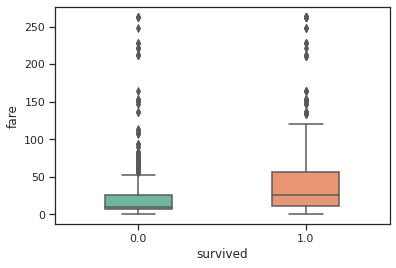

In [ ]:
sns.boxplot("survived", "fare", width=0.4, data=df)
plt.show()

Above we see boxplots that shows the **fare** distribution grouped by our target variable (**survival**). The left boxplot corresponds to people that died and the right one to people that survived. Alternatively, we could plot the distribution of fare according to survival

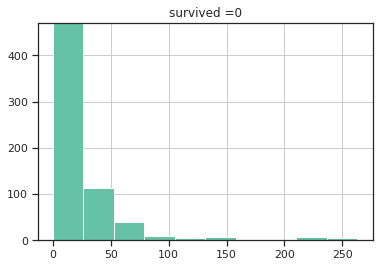

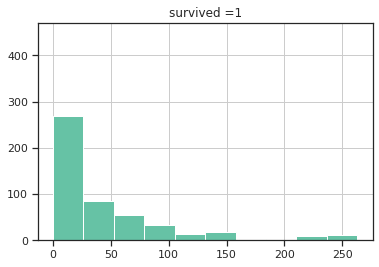

In [ ]:
for r in range(2):
    hist = df[df.survived == r].hist('fare')
    plt.title("survived =" + str(r))
    plt.ylim(0,470)
    plt.show()

Now it's time for some quick plotting. Let's first plot the graph of "Age vs. Survived":

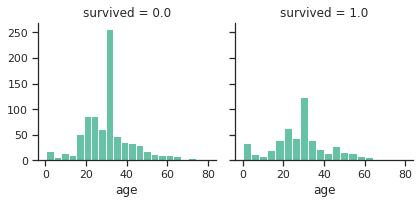

In [ ]:
g = sns.FacetGrid(df, col='survived')
g.map(plt.hist, 'age', bins=20)

Its time to see how the pclass and survived features are related to eachother with a graph:

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


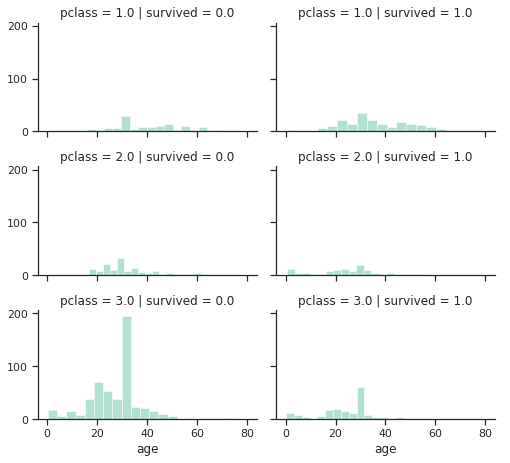

In [ ]:
grid = sns.FacetGrid(df, col='survived', row='pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

Enough of visualization and analytics for now! Let's actually build a K-Means model with the training set. But before that you will need some data preprocessing as well. You can see that not all the feature values are of same type. Some of them are numerical and some of them are not. In order to ease the computation, you will feed all numerical data to the model. Let's see the data types of different features that you have:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1304 non-null   float64
 1   name      1304 non-null   object 
 2   pclass    1304 non-null   float64
 3   sex       1304 non-null   object 
 4   age       1304 non-null   float64
 5   fare      1304 non-null   float64
 6   sibsp     1304 non-null   float64
 7   parch     1304 non-null   float64
 8   ticket    1304 non-null   object 
 9   cabin     292 non-null    object 
 10  embarked  1302 non-null   object 
dtypes: float64(6), object(5)
memory usage: 162.2+ KB


### <font color='red'>Diff.</font>

So, you can see that the following features are non-numeric:

- name (likely no impact to survival)
- ticket
- cabin (there are a lot of missing values)

- sex (many female passengers survived in the Titanic.)
- embarked (there are two missing values)

Before converting them into numeric ones, you might want to do some feature engineering, i.e. features like `name`, `ticket` and `cabin` do not have any impact on the survival status of the passengers. Often, it is better to train your model with only significant features than to train it with all the features, including unnecessary ones. It not only helps in efficient modelling, but also the training of the model can happen in much lesser time. Although, feature engineering is a whole field of study itself, I will encourage you to dig it further. But for this tutorial, know that the features name, ticket and cabin can be dropped and they will not have significant impact on the training of the K-Means model.

In [ ]:
df = df.drop(['name','ticket', 'cabin'], axis=1)

Since there are only two records/samples that have miss values of `embarked`. So, let's drop those two now and this won't affect us much in a modeling step.

In [ ]:
df = df.dropna(subset=['embarked'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1302 non-null   float64
 1   pclass    1302 non-null   float64
 2   sex       1302 non-null   object 
 3   age       1302 non-null   float64
 4   fare      1302 non-null   float64
 5   sibsp     1302 non-null   float64
 6   parch     1302 non-null   float64
 7   embarked  1302 non-null   object 
dtypes: float64(6), object(2)
memory usage: 91.5+ KB


Now that the dropping part is done let's convert the `sex` and `embarked` features to numerical ones (only `sex` and `embarked` are remaining now which are non-numeric features). You will do this using a technique called [Label Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [ ]:
labelEncoder = LabelEncoder()
labelEncoder.fit(df['sex'])
df['sex'] = labelEncoder.transform(df['sex'])
labelEncoder.fit(df['embarked'])
df['embarked'] = labelEncoder.transform(df['embarked'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1302 non-null   float64
 1   pclass    1302 non-null   float64
 2   sex       1302 non-null   int64  
 3   age       1302 non-null   float64
 4   fare      1302 non-null   float64
 5   sibsp     1302 non-null   float64
 6   parch     1302 non-null   float64
 7   embarked  1302 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 91.5 KB


In [ ]:
df.head()

,survived,pclass,sex,age,fare,sibsp,parch,embarked
0,1.0,1.0,0,29.0000,211.3375,0.0,0.0,2
1,1.0,1.0,1,0.9167,151.5500,1.0,2.0,2
2,0.0,1.0,0,2.0000,151.5500,1.0,2.0,2
3,0.0,1.0,1,30.0000,151.5500,1.0,2.0,2
4,0.0,1.0,0,25.0000,151.5500,1.0,2.0,2


### Define which columns are predictor variables (descriptive features) and a target variable (labels)

In [ ]:
#Isolate the descriptive features we are interested in
X = df[df.columns[1:]]
Y = np.array(df["survived"])

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1302 non-null   float64
 1   sex       1302 non-null   int64  
 2   age       1302 non-null   float64
 3   fare      1302 non-null   float64
 4   sibsp     1302 non-null   float64
 5   parch     1302 non-null   float64
 6   embarked  1302 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 81.4 KB


As we can see, all descriptive features are now in float. They are perfect for modelling.

In [ ]:
Y

array([1., 1., 0., ..., 0., 0., 0.])

### Partition Data
Perform simple data partitioning into 2 sets, including training and test sets with the ratio of 70:30.

In [ ]:
from sklearn.model_selection import train_test_split

#Simple partition data into trainig + validation and test sets with 70% and 30% respectively.
X_train, X_test, y_train, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [ ]:
correct = 0
for i in range(len(X_test)):
    predict_me = np.array(X_test.iloc[i])
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = knn.predict(predict_me)
    if prediction[0] == y_test[i]:
        correct += 1

print(correct/len(X_test))

0.6777493606138107


In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [ ]:
correct = 0
for i in range(len(X_test)):
    predict_me = np.array(X_test.iloc[i])
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = knn.predict(predict_me)
    if prediction[0] == y_test[i]:
        correct += 1

print(correct/len(X_test))

0.7135549872122762


In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')


In [ ]:
predicted = knn.predict(X_test)
predicted

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0.

In [ ]:
num_pos = (predicted == 1).sum()
num_neg = (predicted == 0).sum()
print( "Number of passengers predicted positive for being survived: %d" % num_pos )
print( "Number of passengers predicted negative for being survived: %d" % num_neg )

Number of passengers predicted positive for being survived: 104
Number of passengers predicted negative for being survived: 287


In [ ]:
print("Predictions\n", predicted)
print("Correct labels\n", y_test)

Predictions
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted)

0.7135549872122762